In [1]:
import mne
import os
import autoreject as aj
import numpy as np
import pandas as pd
from pathlib import Path

DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
path = DATA_PATH / "prp/post_ica"
out_path = DATA_PATH / "prp/epoched"
subj_names = []

for file in path.glob("*"):
    if 'raw.fif' in file.name:
        subj_names.append(file.name.split('_')[2])

print(subj_names)

['VP6', 'VP8', 'VP5', 'VP3', 'VP24', 'VP13', 'VP16', 'VP11', 'VP23', 'VP21', 'VP18', 'VP10', 'VP19', 'VP17', 'VP15', 'VP9', 'VP7', 'VP22', 'VP20', 'VP1', 'VP12', 'VP14', 'VP2']


In [8]:
raw = mne.io.read_raw_fif(path / f"post_ica_VP1_raw.fif", preload=True, verbose=False)

In [18]:
epochs, events = create_epochs_t1(-.25, 2, raw)

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5399 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 18 64]
Adding metadata with 3 columns
952 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 952 events and 1153 original time points ...
0 bad epochs dropped


<Axes: xlabel='rt', ylabel='Count'>

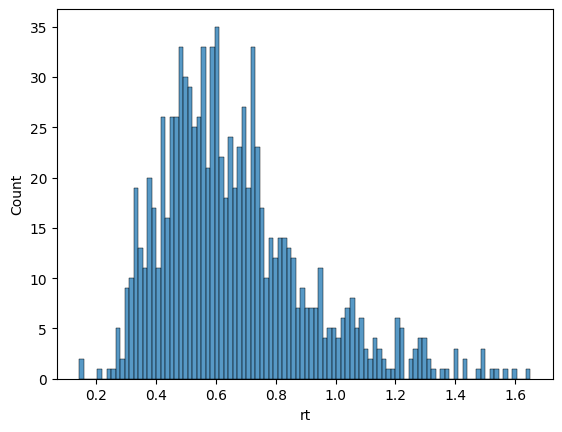

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(epochs.metadata.rt, bins=100)


In [12]:
events, metadata, s1_indices, _ = get_events(raw, -.25, 2)

Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5399 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 18 64]


In [15]:
metadata


,event_name,condition/short,condition/long,stimulus/t1,stimulus/t2,response/t2,response/t1,condition,first_condition,valid,trial_index
0,stimulus/t1,NaN,0.000000,0.000000,1.197266,1.734375,1.406250,0.000000,long,True,0
1,stimulus/t2,NaN,1.667969,1.667969,0.000000,0.537109,0.208984,1.667969,long,True,0
2,stimulus/t1,NaN,0.000000,0.000000,1.177734,1.757812,0.685547,0.000000,long,True,1
3,stimulus/t2,1.689453,NaN,1.689453,0.000000,0.580078,NaN,1.689453,long,True,1
4,stimulus/t1,0.000000,NaN,0.000000,0.275391,0.810547,0.537109,0.000000,short,True,2
...,...,...,...,...,...,...,...,...,...,...,...
2136,stimulus/t2,NaN,1.388672,1.388672,0.000000,0.273438,1.705078,1.388672,long,True,1076
2137,stimulus/t1,NaN,0.000000,0.000000,1.177734,1.564453,0.316406,0.000000,long,True,1077
2138,stimulus/t2,1.488281,NaN,1.488281,0.000000,0.386719,1.962891,1.488281,long,True,1077
2139,stimulus/t1,0.000000,NaN,0.000000,0.277344,0.937500,0.474609,0.000000,short,True,1078


In [ ]:
# def create_epochs_t1(tmin, tmax, raw):
#     events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)
#     metadata = metadata.iloc[s1_indices]
#     # events = events[s1_indices]
#     events = [events[i] for i in s1_indices]
    
#     keep_cols = ['response/t1', 'first_condition', 'trial_index']
#     metadata = metadata[keep_cols]
#     metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
#     metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

#     event_id = {'stimulus/t1': 11} # S1 will be the onset of the epochs

#     # Create epochs
#     epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
#                 baseline=(None, 0), preload=True, 
#                 verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
#                 metadata=metadata, reject_by_annotation=True, reject=None)
    
#     return epochs, events

In [ ]:
# def create_epochs_t2(tmin, tmax, raw):
#     events, metadata, s1_indices, s2_indices = get_events(raw, tmin, tmax)
#     metadata_2 = metadata.iloc[s1_indices]
#     metadata = metadata.iloc[s2_indices]
#     events = [events[i] for i in s2_indices]
    
#     # Move up RTs of S2 based on short/long SOA because they are originally based on S1
#     metadata_2['response/t2'] = np.where(metadata_2['first_condition']=='short', metadata_2['response/t2']-0.3, metadata_2['response/t2']-1.2)
#     metadata['response/t2'] = metadata['response/t2'] - 0.024
#     metadata.reset_index(drop=True, inplace=True)
#     metadata_2.reset_index(drop=True, inplace=True)

#     # Create a mapping from trial_index to first_condition from metadata_2 and update first_condition column in metadata only where trial_index matches
#     update_map = metadata_2.set_index('trial_index')['first_condition']
#     metadata['first_condition'] = metadata['trial_index'].map(update_map).fillna(metadata['first_condition'])

#     update_map = metadata_2.set_index('trial_index')['response/t2']
#     metadata['response/t2'] = metadata['trial_index'].map(update_map).fillna(metadata['response/t2'])
    
#     keep_cols = ['response/t2', 'first_condition', 'trial_index']
#     metadata = metadata[keep_cols]
#     metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
#     metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

#     event_id = {'stimulus/t2': 64} # S2 will be the onset of the epochs

#     # Create epochs
#     epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
#                 baseline=(None, 0), preload=True, 
#                 verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
#                 metadata=metadata, reject_by_annotation=True, reject=None)
    
#     return epochs, events

In [ ]:
# def create_epochs_trial(tmin, tmax, raw):
#     events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)
#     metadata = metadata.iloc[s1_indices]
#     # events = events[s1_indices]
#     events = [events[i] for i in s1_indices]
    
#     keep_cols = ['response/t2', 'first_condition', 'trial_index']
#     metadata = metadata[keep_cols]
#     metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
#     metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names

#     event_id = {'stimulus/t1': 11} # S1 will be the onset of the epochs

#     # Create epochs
#     epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
#                 baseline=(None, 0), preload=True, 
#                 verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
#                 metadata=metadata, reject_by_annotation=True, reject=None)
    
#     return epochs, events

In [4]:
def autoreject(epochs, raw):
    picks = mne.pick_types(raw.info, eeg=False, stim=False, eog=False, include=['C3', 'C4', 'POz', 'FCz'], exclude=[])
    ar = aj.AutoReject()
    
    # Fit on the first 20 epochs to save time
    ar.fit(epochs[0:20])
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)

    return epochs_ar

In [5]:
# Given a tuple of ndarrays (index 0 containing event, index 1 containing time)
# Return fixed events
def merge_events_stim(stim):
    stim_new = stim[0].copy()
    mapping = {
        # stim/t1
        12: 11,
        20: 11,
        21: 11,
        22: 11,
        23: 11,
        31: 11,
        32: 11,
        # stim/t2
        65: 64,
        66: 64,
        67: 64,
        68: 64,
        128: 64,
        129: 64,
        130: 64,
        131: 64,
        132: 64,
        133: 64,
        # response/t1
        2: 1,
        3: 1,
        # response/t2
        5: 4,
        # block
        7: 6,
    }
    for k, v in mapping.items():
        stim_new[stim[0] == k] = v
    return stim_new


def find_condition(events):
    # If stim_t2 occurs within 300 or 1200ms from stim_t1, include condition
    # Otherwise exclude that stim_t1 timepoint
    new_events = []
    
    stims_t1 = events[events[:, 2] == 11, 0]
    stims_t2 = events[events[:, 2] == 64, 0]

    # Identify short/long SOA based on time between stims
    for idx, onset in enumerate(stims_t1):
        diffs = stims_t2[stims_t2 > onset] - onset
        # diffs[0] is distance (in samples?) to closest t2 stim
        if 600 < diffs[0] < 615:  # Most often 602/603
            # Long SOA
            new_events.append([onset, 0, 256])
        elif 140 < diffs[0] < 151:  # Most often 141/142/143
            # Short SOA
            new_events.append([onset, 0, 512])
        else:
            # Invalid
            new_events.append([onset, 0, 1024])
    return new_events


def get_events(raw, tmin, tmax):
    stimulus_id = {"stimulus/t1": 11, "stimulus/t2": 64}  # Stimulus trigger
    condition_id = {"condition/short": 512, "condition/long": 256}  # Condition trigger
    response_id = {"response/t2": 4, "response/t1": 1}  # Response triggers
    event_id = condition_id | stimulus_id | response_id  # All retained events

    # Correct event trigger values in raw data
    stim_idx = raw.ch_names.index("Status")
    raw._data[stim_idx] = merge_events_stim(raw["Status"])

    # IMPORTANT, set consecutive=True so not only ascending trigger values are recorded as new events
    events = mne.find_events(raw, shortest_event=1, consecutive=True)

    # find_condition adds condition trigger
    new_events = np.array(find_condition(events))
    # 1, 4, 6, 11, 16, 64

    # Append events to end of array, now has events 256/512 at same onset, but later in array
    events_tmp = np.concatenate((events, new_events))

    # Makes for every event in row_events (11/64, stim/t1 and stim/t2)
    # a row containing all other events (condition, response)
    metadata, events, event_id = mne.epochs.make_metadata(
        events=events_tmp,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        sfreq=raw.info["sfreq"],
        row_events=list(stimulus_id.keys()),
        keep_first=["condition"],
    )
    # keep_first causes first_condition to be set for stim/t2 based on the NEXT trial
    # if 'condition' is not 0 (condition was not set at the same time as event), set first_condition to shift(1) value (previous row)
    metadata.loc[(metadata['condition'] != 0), 'first_condition'] = metadata['first_condition'].shift(1)

    # Trial is valid if first_condition is not None AND response/t1 is not NaN AND response/t2 is not NaN, in these cases we know that there was ~300/1200ms between stimuli and responses were given in the time between stim/t1 and next stim/t1
    metadata.loc[metadata["event_name"] == "stimulus/t1", "valid"] = (
        metadata["first_condition"].notna()
        & metadata["response/t1"].notna()
        & metadata["response/t2"].notna()
    )

    # t2 'trials' are valid when the previous row was stim/t1 and it was valid, AND response/t2 is not na
    metadata.loc[metadata["event_name"] == "stimulus/t2", "valid"] = (
        (metadata["event_name"].shift(1) == "stimulus/t1")
        & (metadata["valid"].shift(1) == True)
        & (metadata["response/t2"].notna())
    )

    metadata = metadata.reset_index(drop=True)

    trial_index = 0
    # Assign trial index to each row, the same number for every stimulus/t1 that is followed by a stimulus/t2
    for row in metadata.itertuples():
        if row.event_name == "stimulus/t1":
            metadata.at[row.Index, "trial_index"] = trial_index
            trial_index += 1
        elif row.event_name == "stimulus/t2":
            if metadata.at[row.Index - 1, "event_name"] == "stimulus/t1":
                metadata.at[row.Index, "trial_index"] = trial_index - 1
            else:
                metadata.at[row.Index, "trial_index"] = trial_index
                trial_index += 1
    metadata['trial_index'] = metadata.trial_index.astype(int)

    # find stim/t1 and stim/t2 indices
    s1_indices = metadata[(metadata["event_name"] == "stimulus/t1") & (metadata["valid"] == True)].index.tolist()
    s2_indices = metadata[(metadata["event_name"] == "stimulus/t2") & (metadata["valid"] == True)].index.tolist()

    return events, metadata, s1_indices, s2_indices

In [7]:
def create_epochs_t1(tmin, tmax, raw):
    events, metadata, s1_indices, _ = get_events(raw, tmin, tmax)

    s1_indices = [i for i in s1_indices]

    metadata = metadata.iloc[s1_indices]
    events = [events[i] for i in s1_indices]
    keep_cols = ['response/t1', 'first_condition', 'trial_index']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names
    event_id = {'stimulus/t1': 11} # S1 will be the onset of the epochs
    
    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events


In [8]:
def create_epochs_t2(tmin, tmax, raw):
    events, metadata, _, s2_indices = get_events(raw, tmin, tmax)

    s2_indices = [i for i in s2_indices]

    metadata = metadata.iloc[s2_indices]
    events = [events[i] for i in s2_indices]
    keep_cols = ['response/t2', 'first_condition', 'trial_index']
    metadata = metadata[keep_cols]
    metadata.reset_index(drop=True, inplace=True) # This allows to preserve the trial number after the rejections performed by the mne.Epochs function
    metadata.columns = ['rt', 'condition', 'trial_index'] # More convenient names
    event_id = {'stimulus/t2': 64} # S1 will be the onset of the epochs
    
    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)
    
    return epochs, events

In [20]:
tmin = -0.25
tmax = 2
for subj in subj_names[1:]:
    print(f'Processing {subj}')
    raw = mne.io.read_raw_fif(path / f"post_ica_{subj}_raw.fif", preload=True, verbose=False)
    events, metadata, _, s2_indices = get_events(raw, tmin, tmax)
    epochs, events_crt = create_epochs_t1(tmin, tmax, raw)
    epochs_t2, events_crt_t2 = create_epochs_t2(tmin, tmax, raw)

    break
    # stimulus/t1 > response/t1
    epochs, events = create_epochs_t1(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(out_path / f"{subj}-t1-epo.fif", overwrite=True)

    # stimulus/t2 > response/t2
    epochs, events = create_epochs_t2(tmin, tmax, raw) 
    epochs = autoreject(epochs, raw)
    epochs.save(out_path / f"{subj}-t2-epo.fif", overwrite=True)

    # TODO: Implement stimulus/t1 > response/t2

Processing VP8
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5944 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5944 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]
Adding metadata with 3 columns
1152 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1152 events and 1153 original time points ...
0 bad epochs dropped
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5944 events found on stim channel Status
Event IDs: [ 1  4  6 11 16 64]
Addin

In [24]:
metadata[:50]

,event_name,condition/short,condition/long,stimulus/t1,stimulus/t2,response/t2,response/t1,condition,first_condition,valid,trial_index
0,stimulus/t1,NaN,0.000000,0.000000,1.195312,NaN,0.851562,0.000000,long,False,0
1,stimulus/t2,NaN,1.937500,1.937500,0.000000,0.832031,NaN,1.937500,long,False,0
2,stimulus/t1,NaN,0.000000,0.000000,1.175781,1.830078,0.646484,0.000000,long,True,1
3,stimulus/t2,1.773438,NaN,1.773438,0.000000,0.654297,NaN,1.773438,long,True,1
4,stimulus/t1,0.000000,NaN,0.000000,0.275391,1.296875,0.847656,0.000000,short,True,2
5,stimulus/t2,NaN,NaN,NaN,0.000000,1.021484,0.572266,NaN,short,True,2
6,stimulus/t1,NaN,0.000000,0.000000,1.177734,1.650391,0.570312,0.000000,long,True,3
7,stimulus/t2,1.587891,NaN,1.587891,0.000000,0.472656,NaN,1.587891,long,True,3
8,stimulus/t1,0.000000,NaN,0.000000,0.277344,1.187500,0.621094,0.000000,short,True,4
9,stimulus/t2,NaN,NaN,NaN,0.000000,0.910156,0.343750,NaN,short,True,4


In [22]:
epochs.metadata

,rt,condition,trial_index
0,0.646484,long,1
1,0.847656,short,2
2,0.570312,long,3
3,0.621094,short,4
4,1.031250,short,5
...,...,...,...
1147,0.535156,long,1182
1148,0.941406,long,1183
1149,0.835938,short,1184
1150,0.521484,long,1185


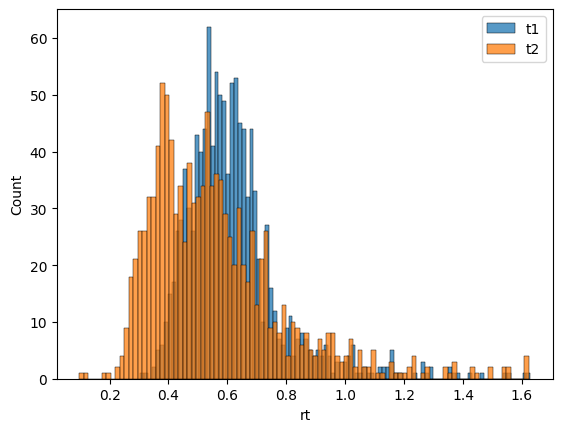

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(epochs.metadata.rt, bins=100, label='t1')
sns.histplot(epochs_t2.metadata.rt, bins=100, label='t2')
plt.legend()
plt.show()

### DEBUGGING

In [117]:
cnt = 0
for subj in subj_names:
    print(subj)
    raw = mne.io.read_raw_fif(path / f"post_ica_{subj}_raw.fif", preload=True, verbose=False)
    print(raw['stim'])
    print(raw.ch_names)
    stim_idx = raw.ch_names.index('Status')
    res = merge_events_stim(raw['Status'])
    raw._data[stim_idx] = res[0]
    print(res[0][:,414450:414480])
    print(raw['stim'][0][:,414450:414480])
    print(raw['Status'][0][:,414450:414480])
    # Consecutive? Assumes that trial onset is first, probably very unlikely that two numbers in sequence will be non-zero so doesn't matter?
    # Q LEENDERT: 
    events = mne.find_events(raw, shortest_event=1)
    events_cons = mne.find_events(raw, shortest_event=1, consecutive=True)
    events = merge_events(events)
    events_cons = merge_events(events_cons)
    # print(events[:,2][:100])
    # print(events_cons[:,2][:100])
    # print(np.unique(events[:,2], return_counts=True))
    # print(np.unique(events_cons[:,2], return_counts=True))
    
    for i in range(1, len(events)):
        if events[i-1, 2] == 64 and events[i, 2] == 64:
            print(events[i-1], events[i])
            cnt += 1
    break
    # for i in range(0, events_cons.shape[0], 100):
    #     print(i)
    #     events_subset = events[i:i+100]
    #     cons_subset = events_cons[i:i+100]
    #     if (events_subset != cons_subset).any():
    #         print(events_subset[:,2])
    #         print(cons_subset[:,2])
    #         print(events_subset[:,0])
    #         print(cons_subset[:,0])
    #         break
    
print(cnt)

VP10
(array([[65536., 65536., 65536., ...,     0.,     0.,     0.]]), array([0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
       3.94999414e+03, 3.94999609e+03, 3.94999805e+03]))
['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'Status', 'eog_h', 'eog_v']
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64. 64.  1.  1.
   1.  1.  1.  1.  0.  0.  0.  0.  0.  0. 

In [91]:
raw['stim'][0]

array([[65536., 65536., 65536., ...,     0.,     0.,     0.]])

In [97]:
raw['stim'][0][:,414450:414480]

array([[ 0.,  0.,  0.,  0.,  0., 64., 64., 64., 64., 64., 64., 67., 67.,
        67., 67., 67.,  3.,  3.,  3.,  3.,  3.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

244 TOTAL occurences where 64 follows 64, 153 if consecutive='increasing' (stim t2), what does this mean?
Likely cases where 64 is followed by not 64 (but a value that is corrected to 64 in merge_events)
solution: merge_events BEFORE find_events

1/2/3 + = 14.392 (all responses t1)
4/5 + = 14.529 (all responses t2)
6 = new block?
11/12/21/22/31/32 += stim t1
130/129/128/67/66/64 (should be 64/128, failure when transmitting int?) = stim t2
16: fixation cross
Normal trial = 16-11-64-1-4/16-11-1-64-4
ALWAYS 16 (fixation) 11 (stim t1) > 1 (resp t1) OR 64 (stim t2) > 4
Not all response events were recorded, participant was too slow? Should not count trials where this is the case

In [33]:
raw['Status'][0]

array([[65536., 65536., 65536., ...,     0.,     0.,     0.]])

In [49]:
raw.info

Measurement date,"November 28, 2016 15:09:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"64 EEG, 1 Stimulus, 2 EOG"
Bad channels,None
EOG channels,"eog_h, eog_v"
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


In [40]:
np.unique(raw['Status'][0].astype(int), return_counts=True)
# 1/2/3 + = 14.392 (all responses t1)
# 4/5 + = 14.529 (all responses t2)
# 6 = new block?
# 11/12/21/22/31/32 += stim t1
# 130/129/128/67/66/64 (should be 64/128, failure when transmitting int?) = stim t2
# 16: fixation cross

(array([    0,     1,     2,     3,     4,     5,     6,    11,    12,
           16,    21,    22,    31,    32,    64,    66,    67,   128,
          129,   130, 65536]),
 array([1949969,    4647,    4990,    4755,    7263,    7266,     143,
           2451,    2384,   14466,    2394,    2418,    2395,    2418,
           7174,       6,       5,    7115,      15,       6,     120],
       dtype=int64))

In [52]:
raw.info

Measurement date,"November 28, 2016 15:09:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"64 EEG, 1 Stimulus, 2 EOG"
Bad channels,None
EOG channels,"eog_h, eog_v"
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


In [ ]:
tmin = -0.25
tmax = 2

for subj in subj_names:
    # Skip those subjects because the data is not valid
    if subj == 'VP6' or subj == 'VP7':
        continue

    raw = mne.io.read_raw_fif(path+"Post ICA/post_ica_%s_raw.fif"%subj, preload=True)
    # epoch = mne.read_epochs(epoch_data_path+subj+'.fif')

    # ================= STIMULUS 1 =================
    epochs, events = create_epochs_t1(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(path+'Stimlocked_fixed_index/%s_epo_t1.fif'%subj, overwrite=True)

    # # ================= STIMULUS 2 =================
    epochs, events = create_epochs_t2(tmin, tmax, raw)
    epochs = autoreject(epochs, raw)
    epochs.save(path+'Stimlocked_fixed_index/%s_epo_t2.fif'%subj, overwrite=True)

    # ================= WHOLE TRIALS =================
    # epochs, events = create_epochs_trial(tmin, tmax, raw)
    # epochs = autoreject(epochs, raw)
    # epochs.save(path+'Stimlocked_fixed_index/%s_epo_trial.fif'%subj, overwrite=True)